In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import random

In [ ]:
def realTime():
    

In [3]:
def formatPrice(n):
    return ("-" if n < 0 else "") + "{0:.2f}".format(abs(n))

In [4]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [5]:
class Deep_Evolution_Strategy:

    def __init__( self, weights, reward_function, save_model, population_size, sigma, learning_rate):
        self.weights = weights
        self.reward_function = reward_function
        self.save_model = save_model
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def get_weight_from_population(self, weights, population):
        weights_population = []
        for index, worker in enumerate(population):
            jittered = self.sigma * worker
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch, print_every):
        lasttime = time.time()
        for step in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            
            for agent in range(self.population_size):
                random_weights = []
                
                for weight in self.weights:
                    random_weights.append(np.random.randn(*weight.shape))
                population.append(random_weights)
            
            for index in range(self.population_size):
                weights_population = self.get_weight_from_population(self.weights, population[index])
                rewards[index] = self.reward_function(weights_population)
            
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            
            for index, weight in enumerate(self.weights):
                agent = np.array([p[index] for p in population])
                self.weights[index] = (weight + self.learning_rate / (self.population_size * self.sigma) * np.dot(agent.T, rewards).T)
            
            if (step + 1) % print_every == 0:
                print('Episode %d. Reward: %f' % (step + 1, self.reward_function(self.weights)))
    
            self.save_model()
        print('Total time:', time.time() - lasttime, 'seconds')

In [6]:
class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[2]
        decision = np.dot(feed, self.weights[1])
        return decision

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights
    
    def save_model(self):
        weights = self.get_weights()
        np.save('models/model3', weights)
    
    def load_model(file):
        weights = np.load('models/model2.npy')
        return weights

In [7]:
class Agent:

    population_size = 33
    sigma = 0.36
    learning_rate = 0.48

    def __init__(self, model, close, capital, window_size):
        self.model = model
        self.close = close
        self.start_capital = capital
        self.window_size = window_size
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.model.save_model,
            self.population_size,
            self.sigma,
            self.learning_rate,
        )

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])

    def get_reward(self, weights):
        capital = self.start_capital 
        l = len(self.close) - 1
        self.model.set_weights(weights)
        state = get_state(self.close, 0, self.window_size + 1)
        inventory = []
        
        for t in range(0, l):
            action = self.act(state)
            
            #hold action == 0
            next_state = get_state(self.close, t + 1, window_size + 1)
            
            #buy
            if action == 1 and capital >= self.close[t]:
                inventory.append(self.close[t])
                capital -= self.close[t]
            
            #sell
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                capital += self.close[t]

            state = next_state
        
        return ((capital - self.start_capital)/self.start_capital)*100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, checkpoint)

    def simulate(self, test, start_capital, maxbuy):
        self.model.set_weights(self.model.load_model())
        capital = start_capital
        state = get_state(test, 0, self.window_size + 1)
        states_sell = []
        states_buy = []
        inventory = []
        total_profit = 0
        l = len(test) - 1
        
        for t in range(0, l):
            action = self.act(state)
            
            #hold action == 0
            next_state = get_state(test, t + 1, window_size + 1)
            
            #buy
            if action == 1 and capital >= test[t] and maxbuy>0:
                capital -= test[t]
                inventory.append(test[t])
                total_profit -= test[t]
                states_buy.append(t)
                maxbuy -= 1 
                print ("Buy: " + formatPrice(test[t]))
            
            #sell
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                capital += test[t]
                total_profit += test[t]
                states_sell.append(t)
                print ("Sell: " + formatPrice(test[t]) + " | Profit: " + formatPrice(test[t] - bought_price))
            
            state = next_state

        print('\nTotal %f' % (total_profit))
        plt.figure(figsize = (40, 20))
        plt.plot(test, label = 'true close', c = 'g')
        plt.plot(
            test, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            test, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [8]:
window_size = 37
test = pd.read_csv('dataset/Vale(TESTE2).csv')
test = test[::-1]
data = pd.read_csv('dataset/Vale.csv')
data = data[::-1]
close = data.Fechamento.values.tolist()
test = test.Fechamento.values.tolist()

In [9]:
model = Model(window_size, 602, 3)
agent = Agent(model, close, 50, window_size)

In [33]:
agent.fit(200, 10)

Episode 10. Reward: 363.660000
Episode 20. Reward: 615.100000
Episode 30. Reward: 508.400000
Episode 40. Reward: 568.960000
Episode 50. Reward: 710.120000
Episode 60. Reward: 802.000000
Episode 70. Reward: 972.720000
Episode 80. Reward: 1025.920000
Episode 90. Reward: 1040.360000
Episode 100. Reward: 1074.940000
Episode 110. Reward: 729.740000
Episode 120. Reward: 1138.320000
Episode 130. Reward: 1186.100000
Episode 140. Reward: 1256.540000
Episode 150. Reward: 1318.100000
Episode 160. Reward: 1354.280000
Episode 170. Reward: 1382.340000
Episode 180. Reward: 1406.080000
Episode 190. Reward: 1405.340000
Episode 200. Reward: 1443.680000
Total time: 201.74964499473572 seconds


Buy: 42.74
Sell: 45.50 | Profit: 2.76
Buy: 46.25
Sell: 42.46 | Profit: -3.79
Buy: 42.02
Sell: 45.88 | Profit: 3.86
Buy: 45.49
Sell: 45.80 | Profit: 0.31
Buy: 46.83
Sell: 46.74 | Profit: -0.09
Buy: 49.97
Sell: 50.70 | Profit: 0.73
Buy: 50.55
Sell: 50.56 | Profit: 0.01
Buy: 50.05
Sell: 50.28 | Profit: 0.23
Buy: 50.93
Sell: 52.60 | Profit: 1.67
Buy: 51.78
Sell: 53.39 | Profit: 1.61
Buy: 51.76
Sell: 51.48 | Profit: -0.28
Buy: 51.33
Sell: 53.10 | Profit: 1.77

Total 8.790000


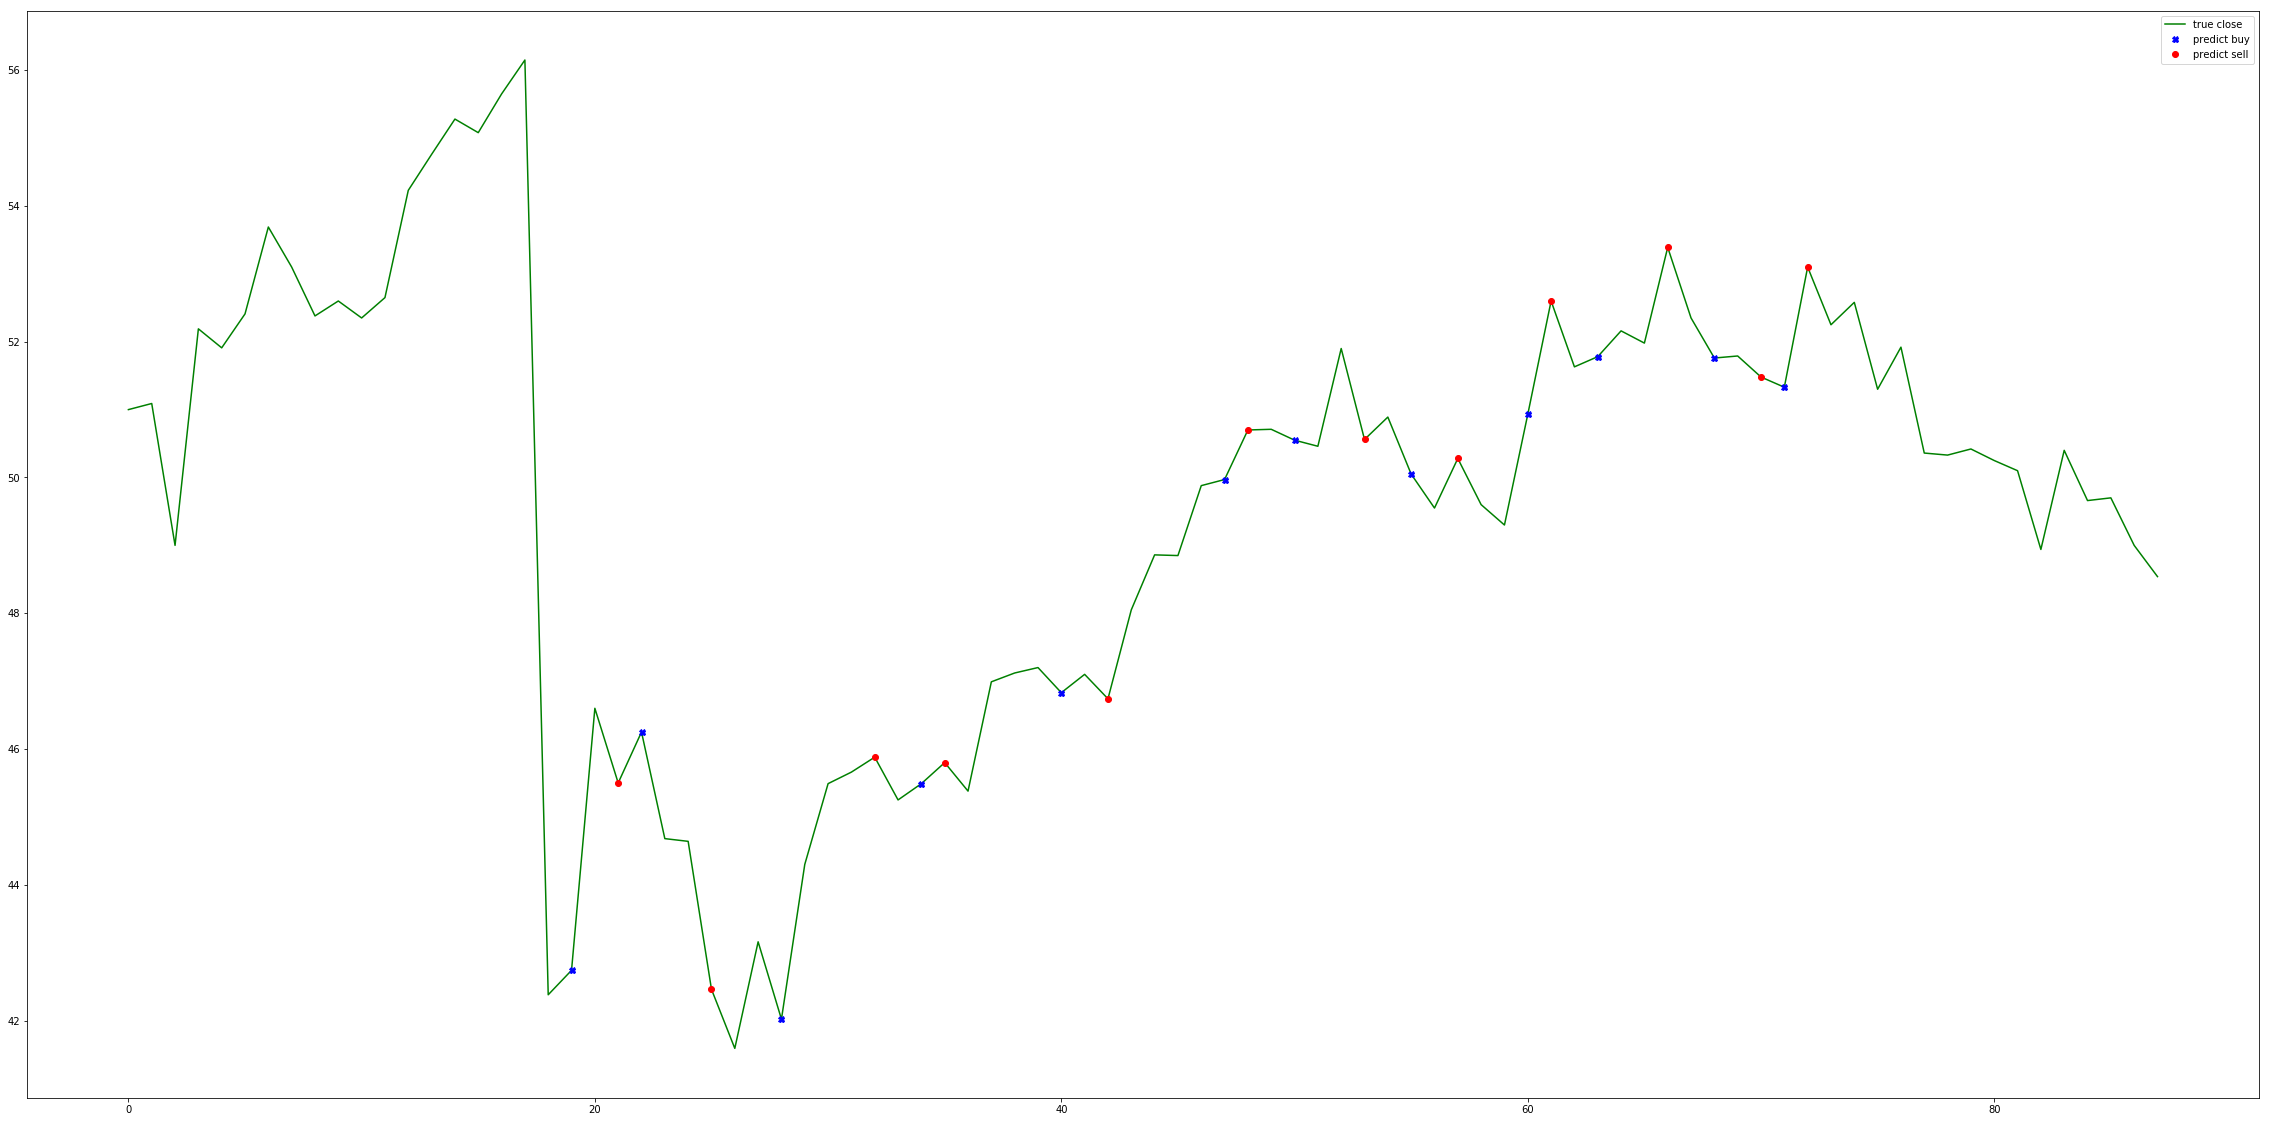

In [10]:
agent.simulate(test, 50, 12)